In [1]:
# Uncomment if needed
!pip install pandas numpy scikit-learn imbalanced-learn joblib
!pip install tensorflow transformers datasets torch
!pip install matplotlib seaborn ipywidgets
!pip install xgboost catboost streamlit

import pandas as pd
import numpy as np
import re, os, joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kagglehub
path = kagglehub.dataset_download("datasnaek/mbti-type") 
print("Dataset path:", path) 
# List files 
print(os.listdir(path)) 
# Load dataset 
df = pd.read_csv(os.path.join(path, "mbti_1.csv")) 
# Preview data 
df.head()

Dataset path: C:\Users\Nafiul Nabil\.cache\kagglehub\datasets\datasnaek\mbti-type\versions\1
['mbti_1.csv']


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
df.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["clean_posts"] = df["posts"].apply(clean_text)
df.head()

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten ...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know tha...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...


In [5]:
df.tail()

,type,posts,clean_posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,just because i always think of cats as fi dom...
8671,ENFP,'So...if this thread already exists someplace ...,soif this thread already exists someplace else...
8672,INTP,'So many questions when i do these things. I ...,so many questions when i do these things i wo...
8673,INFP,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...
8674,INFP,'It has been too long since I have been on per...,it has been too long since i have been on pers...


In [5]:
df["IE"] = df["type"].apply(lambda x: 1 if x[0]=="I" else 0)
df["SN"] = df["type"].apply(lambda x: 1 if x[1]=="S" else 0)
df["TF"] = df["type"].apply(lambda x: 1 if x[2]=="T" else 0)
df["JP"] = df["type"].apply(lambda x: 1 if x[3]=="J" else 0)
df[["IE","SN","TF","JP"]].head()

,IE,SN,TF,JP
0,1,0,0,1
1,0,0,1,0
2,1,0,1,0
3,1,0,1,1
4,0,0,1,1


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["clean_posts"])
y = df[["IE","SN","TF","JP"]]
X.shape, y.shape


((8675, 5000), (8675, 4))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

base_models = {
    "LogReg": LogisticRegression(max_iter=500),
    "SVM": LinearSVC(),
    "NB": MultinomialNB(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=200)
}


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

In [10]:
models = {}
results = {}

In [11]:
for trait in y.columns:
    print(f"\nTraining for {trait}")
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train[trait])

    best_acc = 0
    best_model = None
    trait_scores = {}

    for name, model in base_models.items():
        model.fit(X_res, y_res)
        acc = accuracy_score(y_test[trait], model.predict(X_test))
        trait_scores[name] = acc
        print(f"{name}: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model = model


Training for IE
LogReg: 0.8432
SVM: 0.8133
NB: 0.7476
DT: 0.7435
RF: 0.7925

Training for SN
LogReg: 0.8841
SVM: 0.8726
NB: 0.8133
DT: 0.7781
RF: 0.8582

Training for TF
LogReg: 0.8450
SVM: 0.8150
NB: 0.8046
DT: 0.7078
RF: 0.8156

Training for JP
LogReg: 0.7971
SVM: 0.7608
NB: 0.6922
DT: 0.6772
RF: 0.7268


In [12]:
models[trait] = best_model
results[trait] = trait_scores

In [13]:
print(f"BEST MODEL for {trait}: {best_acc:.4f}")

BEST MODEL for JP: 0.7971


In [14]:
pd.DataFrame(results)

,JP
LogReg,0.797118
SVM,0.760807
NB,0.692219
DT,0.677233
RF,0.726801


In [15]:
os.makedirs("models", exist_ok=True)

joblib.dump(models, "models/ml_models.pkl")
joblib.dump(tfidf, "models/tfidf.pkl")

print("Models saved")


Models saved


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df["clean_posts"])

X_seq = pad_sequences(
    tokenizer.texts_to_sequences(df["clean_posts"]),
    maxlen=300
)
traits = ["IE", "SN", "TF", "JP"]
y_lstm = df[traits]


In [18]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y_lstm, test_size=0.2, random_state=42
)


In [19]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 128),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation="sigmoid")
])

model_lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [20]:
history = model_lstm.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 778ms/step - accuracy: 0.8353 - loss: 0.5914 - val_accuracy: 0.8501 - val_loss: 0.5738
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 790ms/step - accuracy: 0.8452 - loss: 0.5686 - val_accuracy: 0.8473 - val_loss: 0.5810
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 793ms/step - accuracy: 0.8199 - loss: 0.5112 - val_accuracy: 0.7349 - val_loss: 0.6182
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 800ms/step - accuracy: 0.7642 - loss: 0.4147 - val_accuracy: 0.6945 - val_loss: 0.7056
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 810ms/step - accuracy: 0.7339 - loss: 0.3125 - val_accuracy: 0.5749 - val_loss: 0.8207
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 842ms/step - accuracy: 0.7169 - loss: 0.2366 - val_accuracy: 0.5432 - val_loss: 0.9653
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 837ms/step - accuracy: 0.7017 - loss: 0.1843 - val_accuracy: 0.5937 - val_loss: 1.1318
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 824ms/step - accuracy: 0.6912 - loss: 0.1388 - val_accu

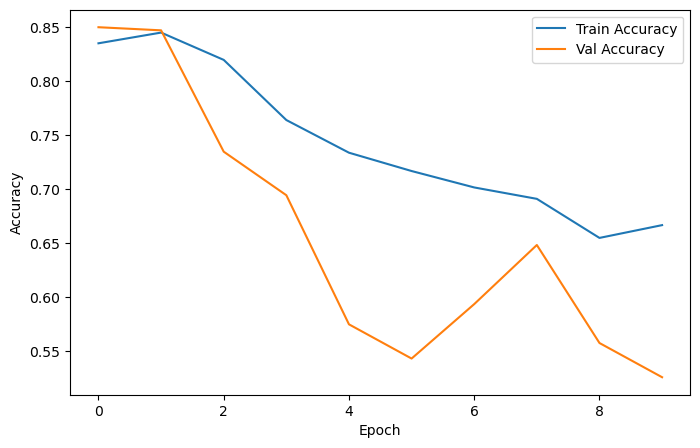

In [21]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [22]:
model_lstm.save("models/lstm_IE.h5")
print("LSTM saved")


LSTM saved


In [28]:
bert_df = df[["clean_posts","IE"]].rename(columns={"clean_posts":"text","IE":"label"})
dataset = Dataset.from_pandas(bert_df)


NameError: name 'Dataset' is not defined

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer_bert(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch", columns=["input_ids","attention_mask","label"])


In [ ]:
model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

args = TrainingArguments(
    output_dir="models/bert_ie",
    num_train_epochs=3,
    per_device_train_batch_size=8
)

trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=dataset
)

trainer.train()


In [ ]:
model_bert.save_pretrained("models/bert_ie")
tokenizer_bert.save_pretrained("models/bert_ie")
print("BERT saved")


In [ ]:
def predict_mbti(text):
    text = clean_text(text)
    vec = tfidf.transform([text])

    mbti = ""
    mbti += "I" if models["IE"].predict(vec)[0] else "E"
    mbti += "S" if models["SN"].predict(vec)[0] else "N"
    mbti += "T" if models["TF"].predict(vec)[0] else "F"
    mbti += "J" if models["JP"].predict(vec)[0] else "P"
    return mbti

predict_mbti("I enjoy deep analytical conversations")


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Example for IE trait
y_pred_IE = models["IE"].predict(X_test)
cm = confusion_matrix(y_test["IE"], y_pred_IE)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: IE")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Example for IE trait
y_prob = models["IE"].predict_proba(X_test)[:,1] if hasattr(models["IE"],"predict_proba") else models["IE"].decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test["IE"], y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: IE")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Example for IE trait
y_prob = models["IE"].predict_proba(X_test)[:,1] if hasattr(models["IE"],"predict_proba") else models["IE"].decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test["IE"], y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: IE")
plt.legend()
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

button = widgets.Button(description="🚀 Train ML Models")
output = widgets.Output()

def train_models_click(b):
    clear_output(wait=True)
    display(button, output)
    with output:
        print("Training ML models...")
        # Paste CELL 8: ML training loop here
        # This allows one-click re-training directly in notebook

button.on_click(train_models_click)
display(button, output)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

text_input = widgets.Textarea(
    value='',
    placeholder='Type something...',
    description='Text:',
    layout=widgets.Layout(width='80%', height='100px')
)

button = widgets.Button(description="Predict MBTI 🚀")
output = widgets.Output()

def predict_button_click(b):
    with output:
        clear_output()
        pred = predict_mbti(text_input.value)
        print(f"✅ Predicted MBTI Type: {pred}")

button.on_click(predict_button_click)
display(text_input, button, output)


In [ ]:
# Save app.py with the Streamlit code from CELL 21
!streamlit run app.py
